In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/DL_Project


/content/drive/My Drive/DL_Project


In [0]:
# Importing necessary libraries
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.models import load_model
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## Loading the data, Data-preprocessing and Spectrogram generation

In [0]:
#Get list of track IDs of the mp3 audio files in the directory
def get_trackid_from_directory(audio_dir):
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids

# Get the path of the mp3 file
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [0]:
AUDIO_DIR = 'fma_small'
trackids = get_trackid_from_directory(AUDIO_DIR)
print(len(trackids))

8000


In [0]:
# Creating Spectrogram
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [0]:
filepath = 'fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
columns = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

#selecting the small subset from fma metadata file
df_all = tracks[columns]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [0]:
# Creating a dictionary of genres to use as class labels
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

In [0]:
# Function to create array of spectrogram images and appending the class labels with each spectrogram
def create_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(dict_genres[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr

### Creating train, validation and test subsets

In [0]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


In [0]:
# Testing subset
X_test, y_test = create_array(df_test)
print(X_test.shape, y_test.shape)
print(y_test[:23])
np.savez('test_arr', X_test, y_test)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
(800, 640, 128) (800,)
[8 6 6 6 6 6 6 3 3 2 2 2 2 2 2 8 8 2 2 2 2 2 2]


In [0]:
# Validation suset
X_valid, y_valid = create_array(df_valid)
np.savez('valid_arr', X_valid, y_valid)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [0]:
# Training Subset
# Train data split into 4 chunks to do the slow pre-processing in phases
def splitDataFrameIntoSmaller(df, chunkSize = 1600): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [0]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 4) (1600, 4) (1600, 4) (1600, 4)


In [0]:
X_train1, y_train1 = create_array(df1_train)
np.savez('train1_arr', X_train1, y_train1)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [0]:
X_train2, y_train2 = create_array(df2_train)
np.savez('train2_arr', X_train2, y_train2)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [0]:

X_train3, y_train3 = create_array(df3_train)
print(X_train3.shape, y_train3.shape)
np.savez('train3_arr', X_train3, y_train3)

Currently processing:  100
Currently processing:  200
Couldn't process:  296
Couldn't process:  297
Couldn't process:  298
Currently processing:  300
Couldn't process:  331
Currently processing:  400
Currently processing:  500
Currently processing:  600
Couldn't process:  698
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600
(1595, 640, 128) (1595,)


In [0]:
X_train4, y_train4 = create_array(df4_train)
print(X_train4.shape, y_train4.shape)
np.savez('train4_arr', X_train4, y_train4)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Couldn't process:  812
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600
(1599, 640, 128) (1599,)


### Concatenate and Shuffle the Training and Validation data

In [0]:
npzfile = np.load('train1_arr.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [0]:
npzfile = np.load('train2_arr.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

['arr_0', 'arr_1']
(1600, 640, 128) (1600,)


In [0]:
npzfile = np.load('train3_arr.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

['arr_0', 'arr_1']
(1595, 640, 128) (1595,)


In [0]:
npzfile = np.load('train4_arr.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

['arr_0', 'arr_1']
(1599, 640, 128) (1599,)


In [0]:
npzfile = np.load('valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [0]:
# Concatenate train data
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394,)


In [0]:
# Convert y data to scale 0-7
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))
y_train = y_train -1
y_valid = y_valid -1
print(np.amin(y_train), np.amax(y_train), np.mean(y_train))

-80.0 0.0 -44.08432967642086
0 7 3.500625586487332


In [0]:
# Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0 0.004296015605854223


In [0]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 0.0 -10.150792034756023


In [0]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
# X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [0]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (6394, 640, 128) (800, 640, 128) (6394,) (800,)


In [0]:
y_train=to_categorize(y_train)
y_valid=to_categorize(y_valid)

In [0]:
np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)

## Parallel CNN - RNN Model

In [0]:
# kernel size : (3,1)
BATCH_SIZE = 64
EPOCH_COUNT = 50
num_classes = 8

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    # Convolutional blocks - 5 convolutional and max pooling layers
    conv_1 = Conv2D(filters = 16, kernel_size = (3,1), strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(max_pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = 32, kernel_size = (3,1), strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(max_pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = 64, kernel_size = (3,1), strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(max_pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = 64, kernel_size = (3,1), strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(max_pool_size_2)(conv_4)
    
    conv_5 = Conv2D(filters = 64, kernel_size = (3,1), strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(max_pool_size_2)(conv_5)

    # flattened to shape 
    flatten1 = Flatten()(pool_5) # output (None,256)

    # Recurrent Block- 1 pooling layer and a bidirectional GRU
    pool_lstm1 = MaxPooling2D(max_pool_size_3, name = 'pool_lstm')(layer)
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    lstm = Bidirectional(GRU(64))(squeezed) # output size (None,128)
    
    # Concatenate the output from CNN and RNN
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat') # output (None,384)
    # Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    model_output = output
    model = Model(model_input, model_output)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [0]:
def train_model(x_train, y_train, x_val, y_val):   
    n_frequency = 128
    n_frames = 640

    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    checkpoint_callback = ModelCheckpoint('weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [0]:
def show_summary_stats(history):
  
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy - epoch plot')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss - epoch plot')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [0]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)


Building model...





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 640, 128, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 319, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  1568        max_pooling2d_1[0][0]            
____________________________________________________________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


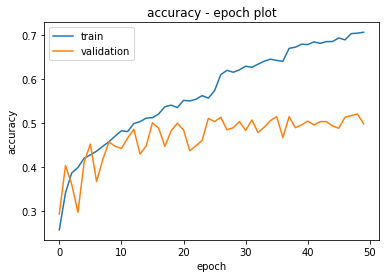

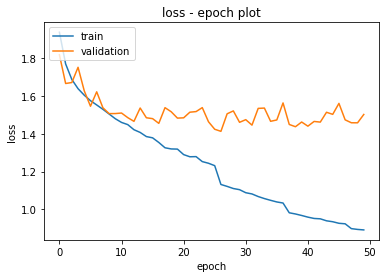

In [0]:
show_summary_stats(history)

In [0]:
y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.46      0.48      0.47       100
 Experimental       0.51      0.49      0.50       100
         Folk       0.57      0.74      0.64       100
      Hip-Hop       0.54      0.54      0.54       100
 Instrumental       0.49      0.48      0.49       100
International       0.76      0.45      0.57       100
          Pop       0.14      0.17      0.15       100
         Rock       0.62      0.55      0.58       100

     accuracy                           0.49       800
    macro avg       0.51      0.49      0.49       800
 weighted avg       0.51      0.49      0.49       800



In [0]:
print(accuracy_score(y_true, y_pred))

0.4875


## Evaluating the CNN-RNN Model on the Test Dataset

In [0]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [0]:
# getting the stored weight values
weights_path = 'weights.best.h5'
model = load_model(weights_path)

In [0]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [0]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0 0.004623813486211768


In [0]:
X_test = np.log(X_test_raw)
y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.68      0.34      0.45       100
 Experimental       0.25      0.31      0.28       100
         Folk       0.25      0.28      0.26       100
      Hip-Hop       0.50      0.87      0.63       100
 Instrumental       0.46      0.39      0.42       100
International       0.49      0.33      0.39       100
          Pop       0.33      0.30      0.32       100
         Rock       0.57      0.55      0.56       100

     accuracy                           0.42       800
    macro avg       0.44      0.42      0.41       800
 weighted avg       0.44      0.42      0.41       800



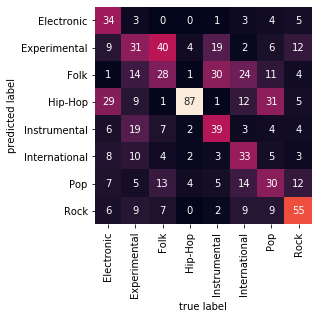

In [0]:
# Heat Map
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
# Testing Accuracy
print(accuracy_score(y_true, y_pred))

0.42125
